In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

from models.AE import AutoEncoder
from utils.loaders import load_mnist, load_model

In [6]:
SECTION = 'ae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = './run/{}/'.format(SECTION)
MODE = 'build'

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [7]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [8]:
AE = AutoEncoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
learning_rate = 0.0005
batch_size = 32
initial_epoch = 0

AE.compile(learning_rate)

AE.train(
    x_train[:1000]
    , batch_size = batch_size
    , epochs = 200
    , run_folder = RUN_FOLDER
    , initial_epoch = initial_epoch
)

Epoch 1/200
31/32 [============================>.] - ETA: 0s - loss: 0.1841
Epoch 1: saving model to ./run/ae/weights/weights.h5
32/32 [==============================] - 1s 13ms/step - loss: 0.1835 - lr: 5.0000e-04
Epoch 2/200
29/32 [==========================>...] - ETA: 0s - loss: 0.0849
Epoch 2: saving model to ./run/ae/weights/weights.h5
32/32 [==============================] - 0s 14ms/step - loss: 0.0837 - lr: 5.0000e-04
Epoch 3/200
29/32 [==========================>...] - ETA: 0s - loss: 0.0673
Epoch 3: saving model to ./run/ae/weights/weights.h5
32/32 [==============================] - 0s 13ms/step - loss: 0.0673 - lr: 5.0000e-04
Epoch 4/200
30/32 [===========================>..] - ETA: 0s - loss: 0.0626
Epoch 4: saving model to ./run/ae/weights/weights.h5
32/32 [==============================] - 0s 13ms/step - loss: 0.0626 - lr: 5.0000e-04
Epoch 5/200
32/32 [==============================] - ETA: 0s - loss: 0.0578
Epoch 5: saving model to ./run/ae/weights/weights.h5
32/32 [====

# Reconstructing original paintings

In [10]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx] 
print("인풋 이미지 shape:", example_images.shape)

# 잠재 공간 포인트 얻기
z_points = AE.encoder.predict(example_images)
print("잠재공간 shape:", z_points.shape)

# 재생성된 이미지 by decoder
reconst_images = AE.decoder.predict(z_points)
print("재생성된 이미지 shape:", reconst_images.shape)

인풋 이미지 shape: (10, 28, 28, 1)
1/1 [==============================] - 0s 27ms/step
잠재공간 shape: (10, 2)
1/1 [==============================] - 0s 11ms/step
재생성된 이미지 shape: (10, 28, 28, 1)


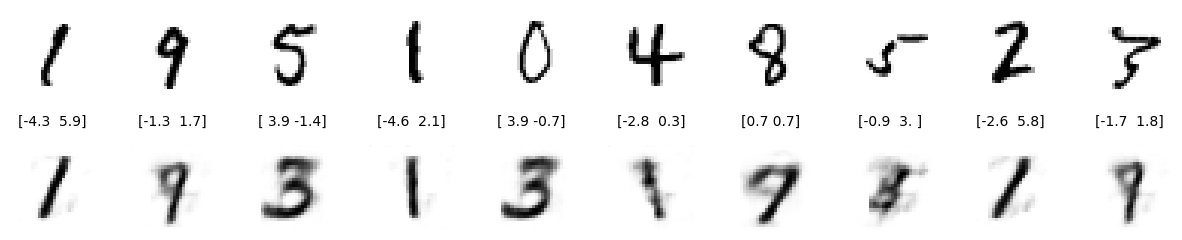

In [11]:
# plot
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze() # use squeeze for removing one-dimension => (28,28)
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i], 1)), fontsize=10, ha='center', transform=ax.transAxes) # 해당 이미지의 latent vector를 텍스트로 표출
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')
    

# Mr N. Coder's wall

In [12]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[exmple_idx]
example_labels = y_test[example_idx]
print(example_images.shape, example_labels.shape)

# latent vector
z_points = AE.encoder.predict(example_images) # 2-dimensional

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0], z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

NameError: name 'exmple_idx' is not defined

# The new generated art exhibition

In [ ]:
figsize = 5

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0], z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x, max_x, size=grid_size * grid_depth)
y = np.random.uniform(min_y, max_y, size=grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0], z_grid[:, 1], c='red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

In [ ]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

In [ ]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')